In [1]:
!pip install tensorflow keras scikeras

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Bidirectional, Dropout, InputLayer, LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    classification_report,
)
from pandas.plotting import scatter_matrix

In [2]:
# Функция для загрузки данных
def load_v5_data(file_name="V5_classification_lr3.csv"):
    if os.path.isfile(file_name):
        return pd.read_csv(file_name, sep=';')  # Указан разделитель ';'
    else:
        print(f"Файл {file_name} не найден!")
        return None

# Загрузка данных
data = load_v5_data()

In [3]:
print(data.head())       # Первые 5 строк
print(data.shape)        # Размер данных
print(data.dtypes)       # Типы данных
data.info()              # Информация о данных
print(data.describe())   # Статистика

   Marital status  Application mode  Application order  Course  \
0               1                17                  5     171   
1               1                15                  1    9254   
2               1                 1                  5    9070   
3               1                17                  2    9773   
4               2                39                  1    8014   

   Daytime/evening attendance\t  Previous qualification  \
0                             1                       1   
1                             1                       1   
2                             1                       1   
3                             1                       1   
4                             0                       1   

   Previous qualification (grade)  Nacionality  Mother's qualification  \
0                           122.0            1                      19   
1                           160.0            1                       1   
2                         

C:\Users\fflyp\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


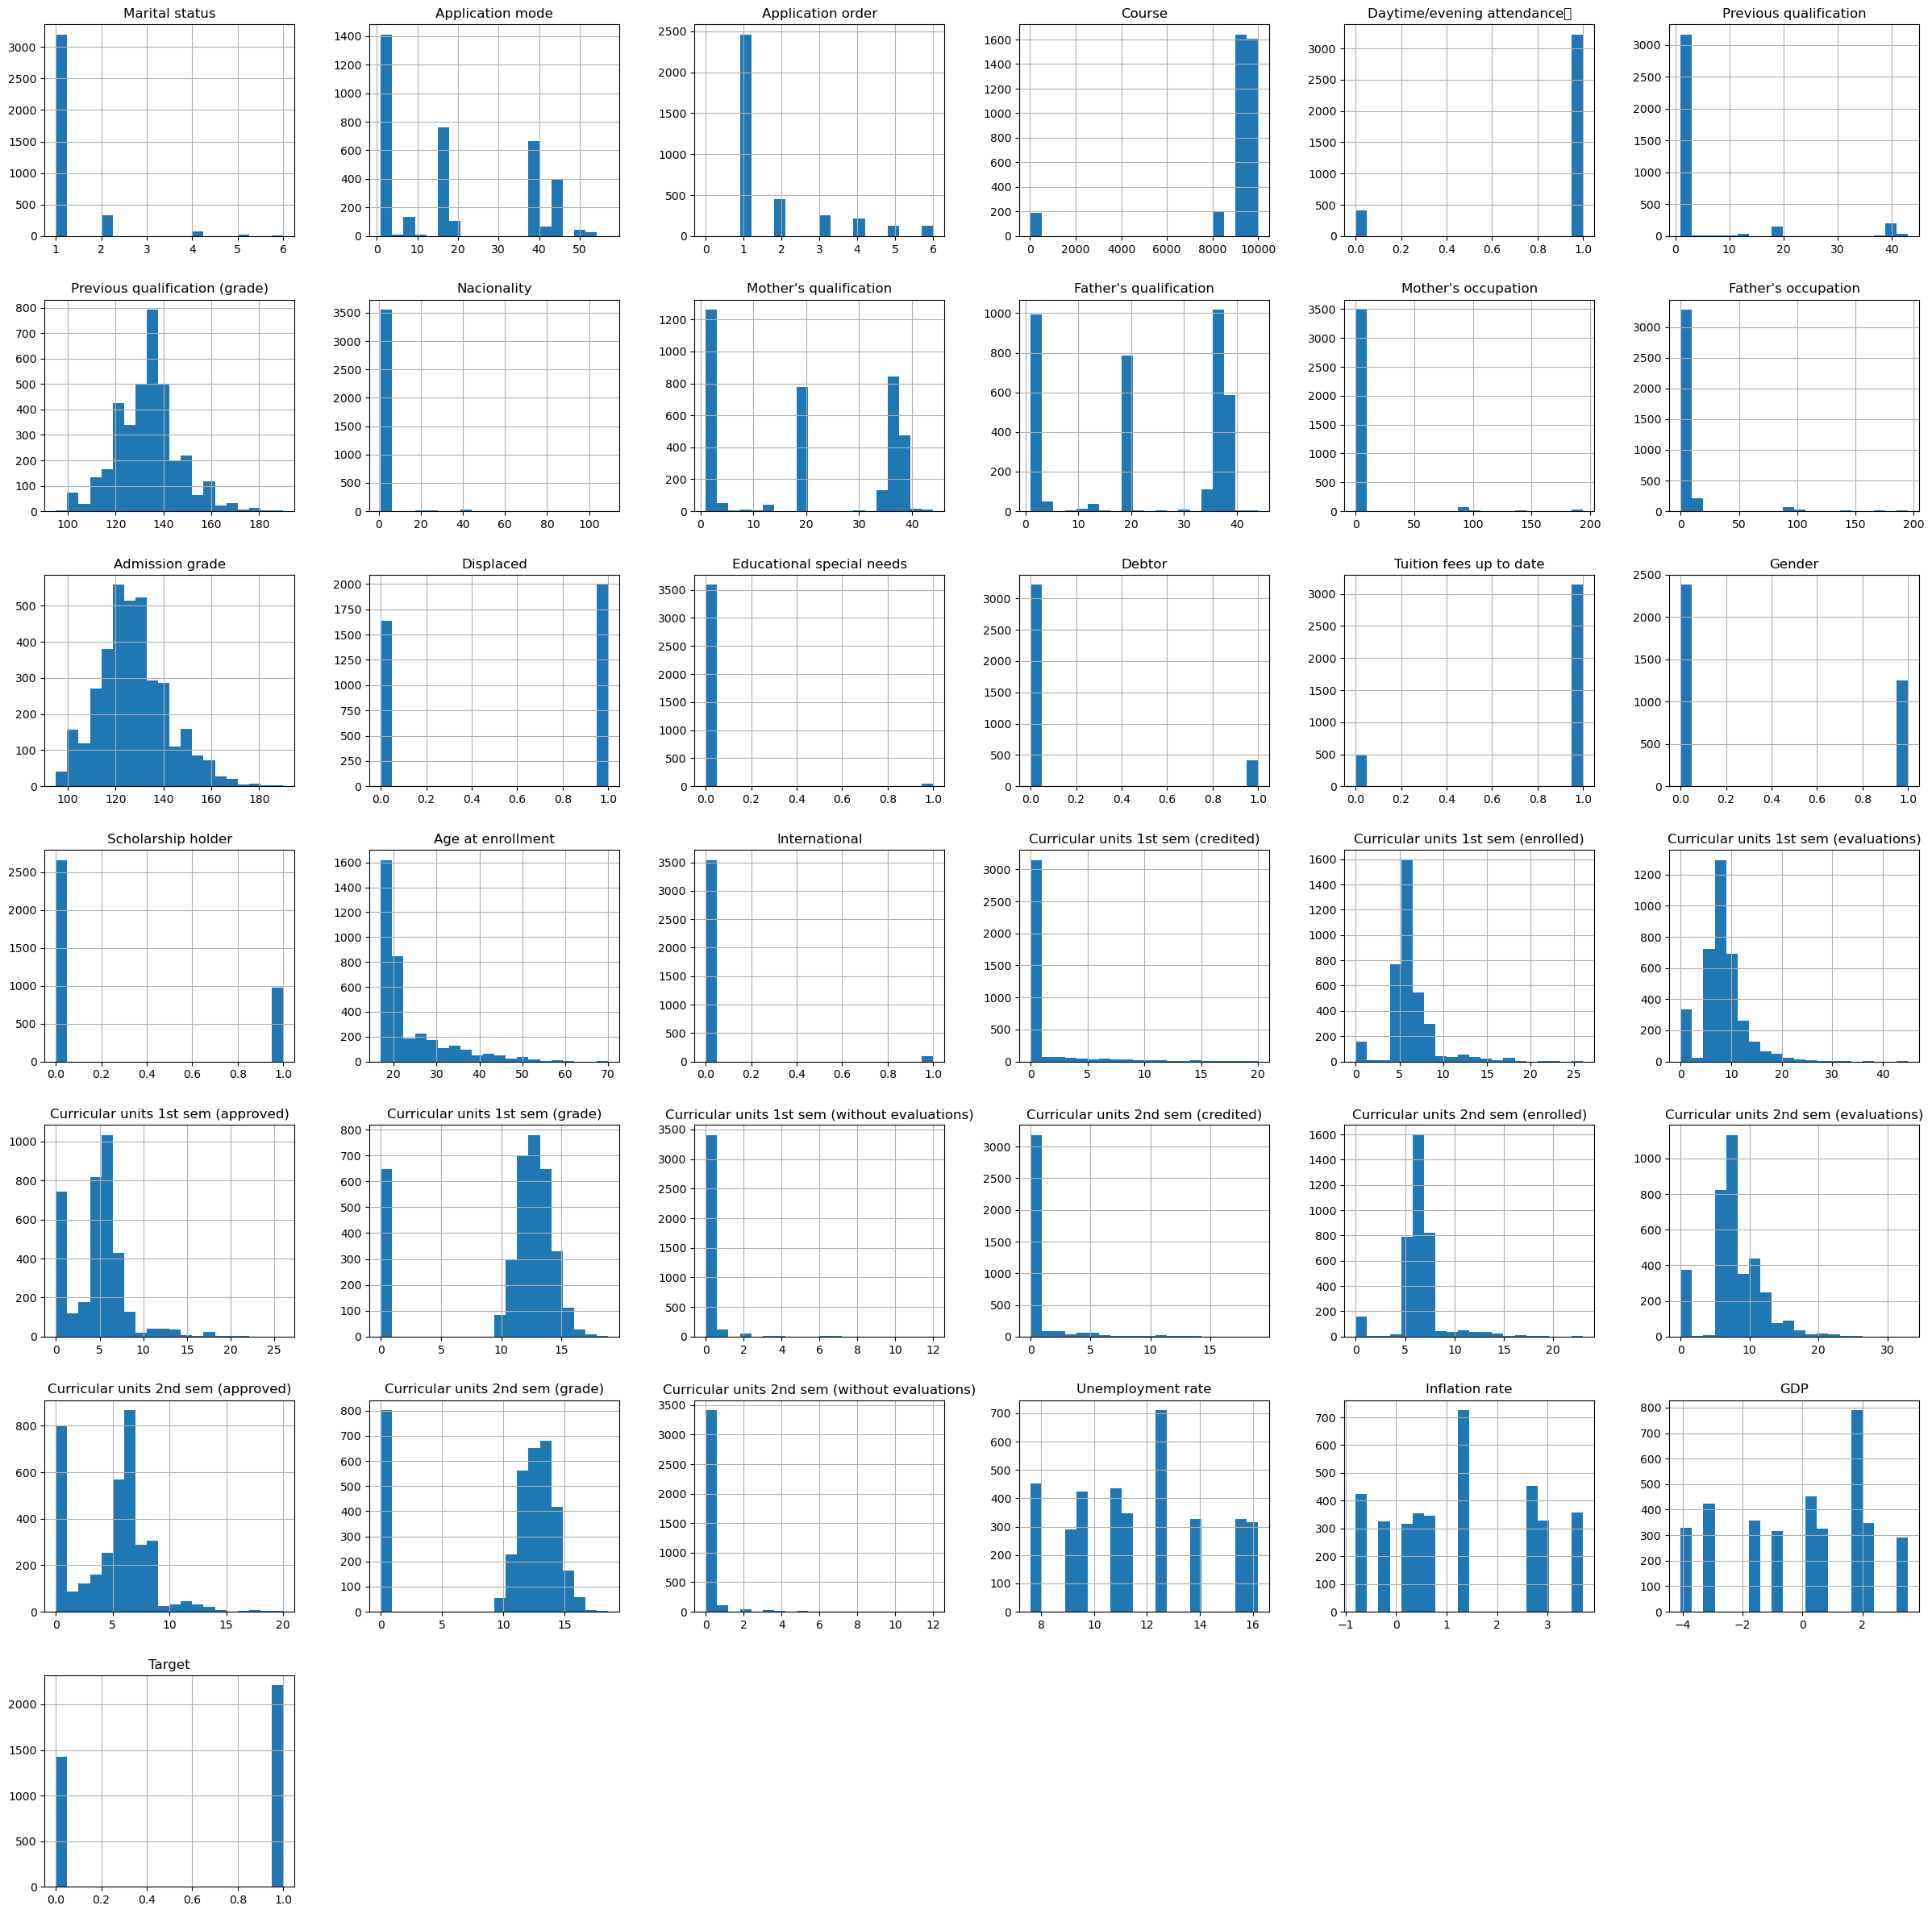

C:\Users\fflyp\AppData\Local\Temp\ipykernel_18040\3598776541.py:44: UserWarning: Glyph 9 (	) missing from current font.
  plt.tight_layout()


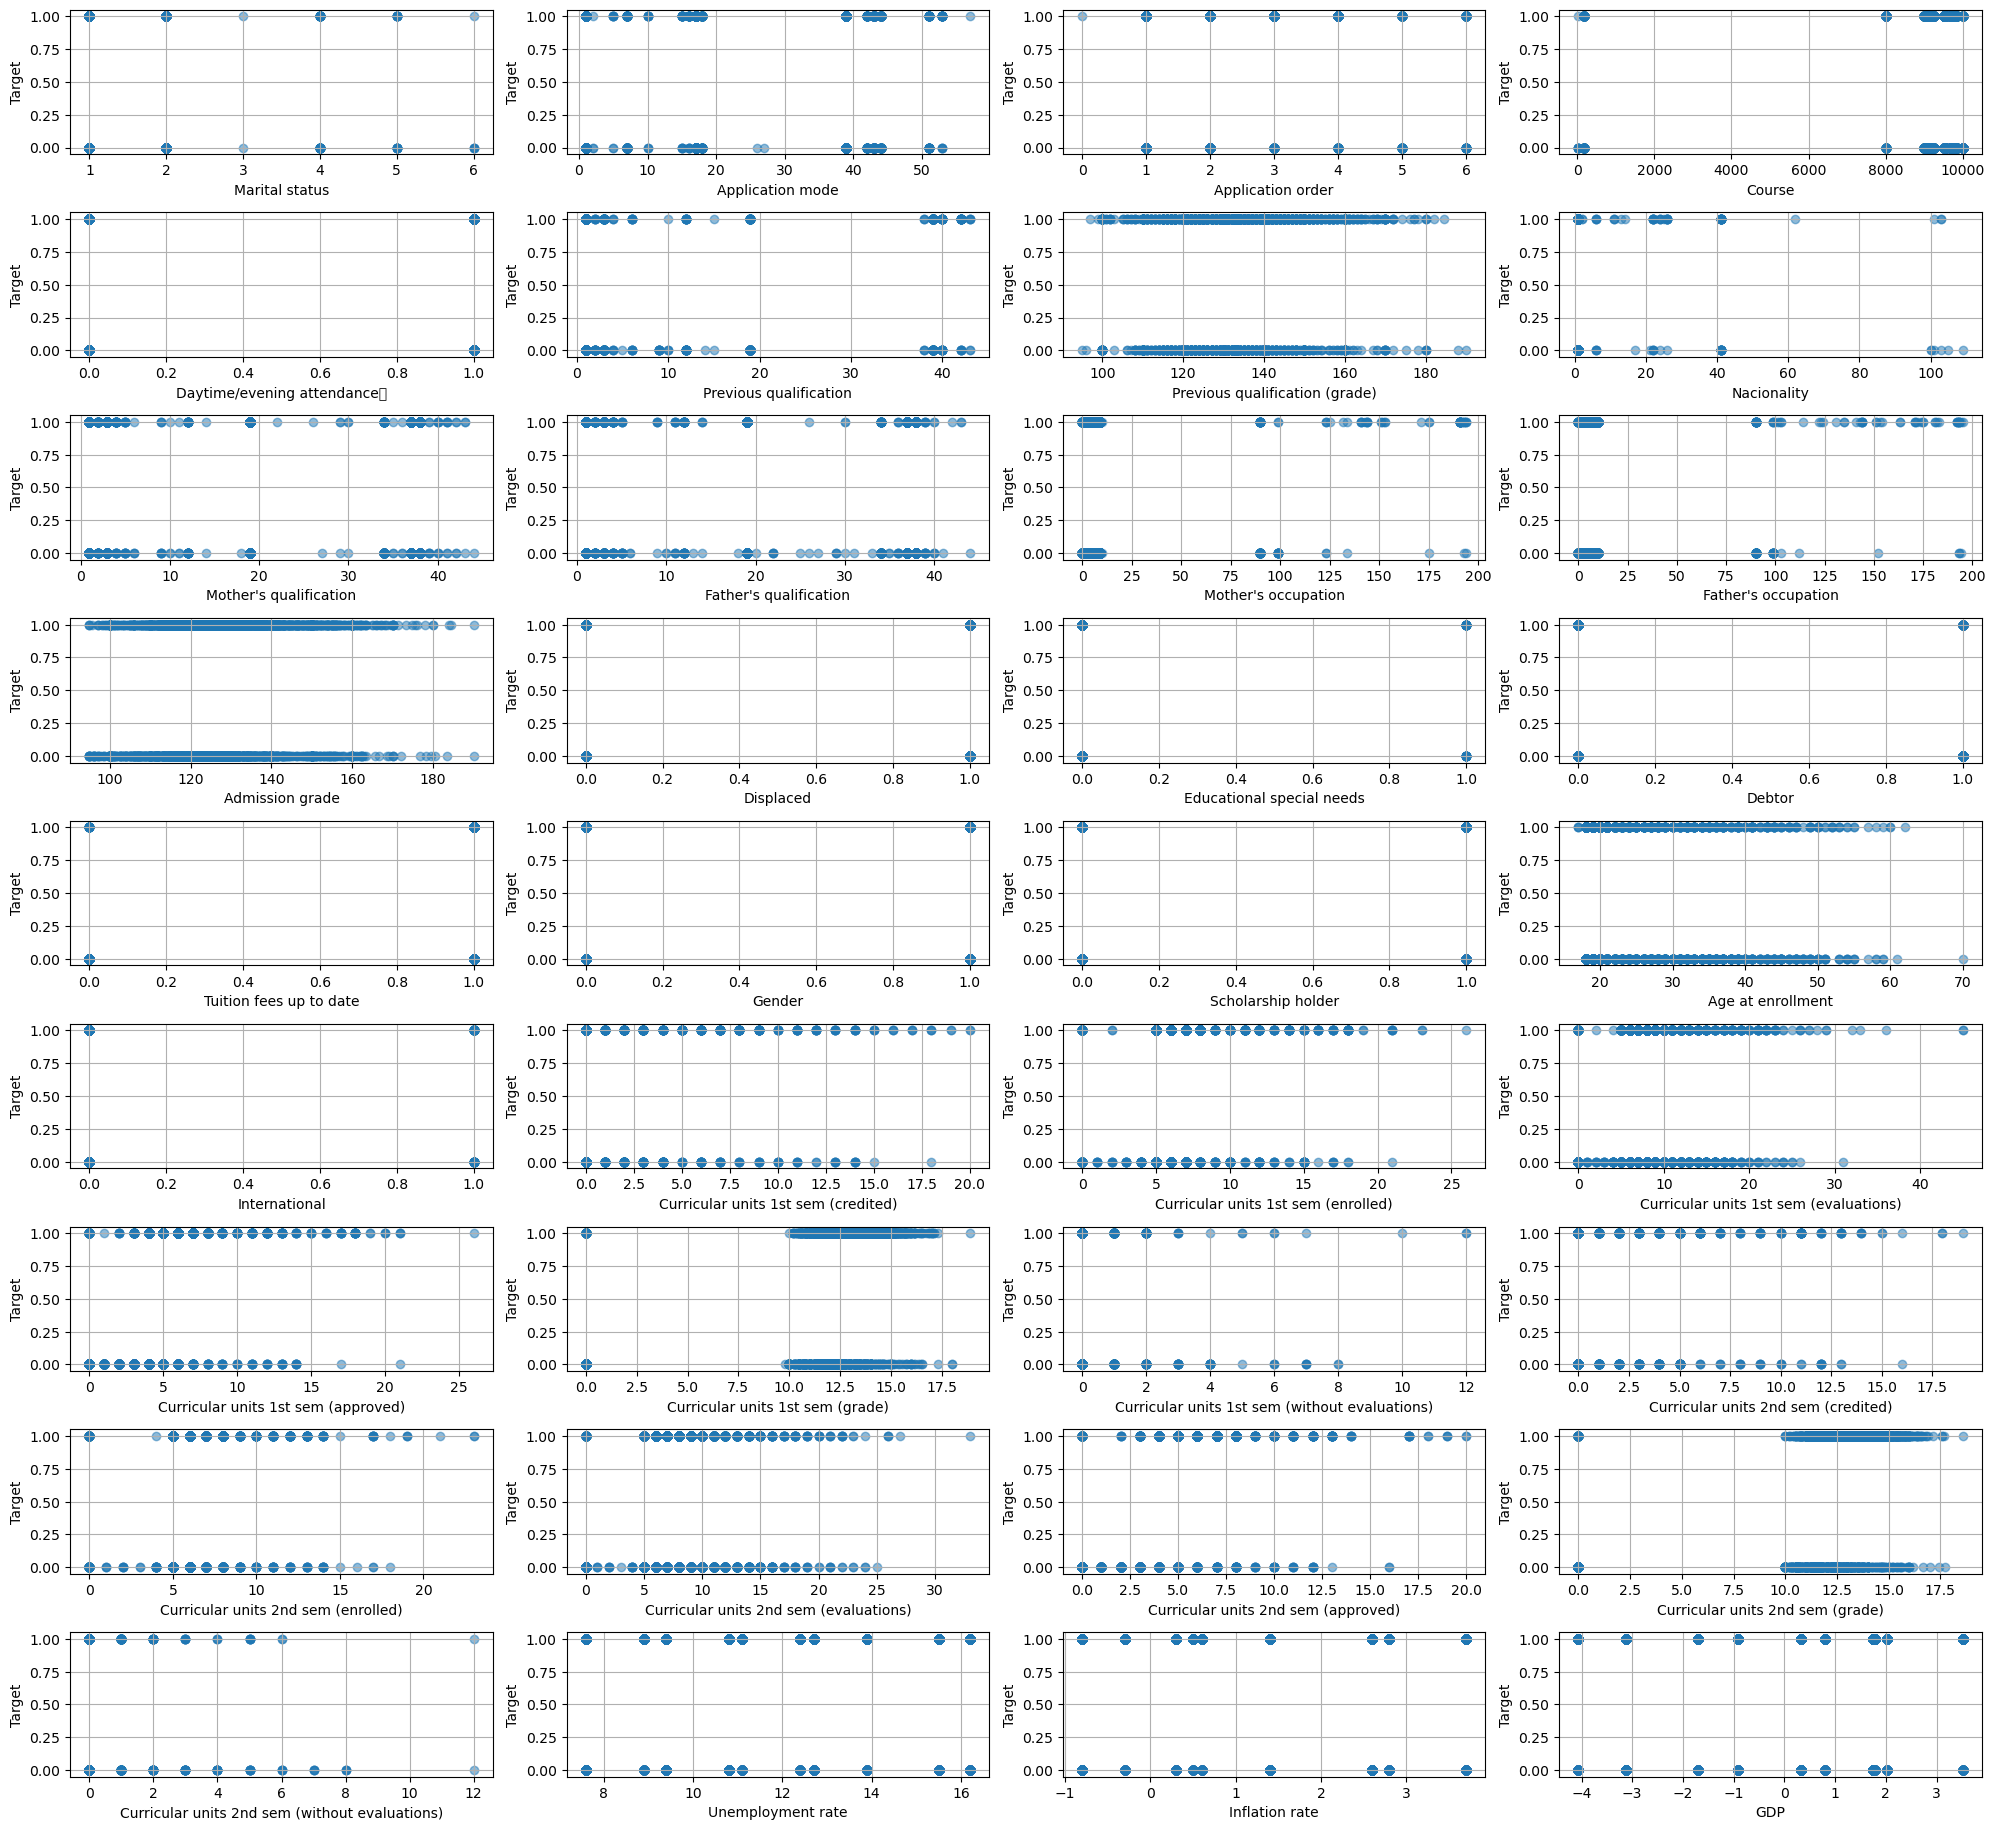

In [4]:
# Удаляем все строки, где 'Target' равен 'enroll'
data = data[data['Target'] != 'Enrolled']

# Преобразуем категориальный признак 'Target' в числовой (если он категориальный)
if data['Target'].dtype == 'object':
    le = LabelEncoder()
    data['Target'] = le.fit_transform(data['Target'])  # Преобразование в числа

# Выбираем все столбцы для анализа
columns_to_plot = data.drop(columns=['Target'])  # Удаляем 'Target' из признаков для диаграмм рассеивания

# Создаем новый DataFrame с зависимостями
data_for_scatter = pd.concat([columns_to_plot, data['Target']], axis=1)

# Гистограммы распределения признаков
data_for_scatter.hist(bins=20, figsize=(30, 30))
plt.show()

# Количество признаков для отображения
num_columns = columns_to_plot.shape[1]

# Определяем количество строк и столбцов для отображения подграфиков
fig, axes = plt.subplots(nrows=(num_columns // 4) + 1, ncols=4, figsize=(20, 20))

# Плоский список осей для итерации
axes = axes.ravel()

# Создаем диаграммы рассеивания для каждого признака
try:
    for idx, column in enumerate(columns_to_plot.columns):
        axes[idx].scatter(data[column], data['Target'], alpha=0.5)
        axes[idx].set_xlabel(column)
        axes[idx].set_ylabel('Target')
        axes[idx].grid(True)
except Exception as e:
    print(f"Error with column {column}: {e}")

# Убираем пустые графики, если есть
for i in range(idx + 1, len(axes)):
    if i < len(axes):  # Проверяем, чтобы индекс был корректным
        fig.delaxes(axes[i])

# Показываем все графики в одном окне
plt.tight_layout()
plt.show()

In [5]:
corr_matrix = data.corr()
print(corr_matrix['Target'].sort_values(ascending=False))

Target                                            1.000000
Curricular units 2nd sem (approved)               0.653995
Curricular units 2nd sem (grade)                  0.605350
Curricular units 1st sem (approved)               0.554881
Curricular units 1st sem (grade)                  0.519927
Tuition fees up to date                           0.442138
Scholarship holder                                0.313018
Curricular units 2nd sem (enrolled)               0.182897
Curricular units 1st sem (enrolled)               0.161074
Admission grade                                   0.128058
Displaced                                         0.126113
Curricular units 2nd sem (evaluations)            0.119239
Previous qualification (grade)                    0.109464
Application order                                 0.094355
Daytime/evening attendance\t                      0.084496
Curricular units 1st sem (evaluations)            0.059786
Curricular units 2nd sem (credited)               0.0524

In [6]:
X = data.drop(['Target'], axis=1)
y = data['Target']  # Целевой признак

# Отбор признаков с помощью SelectKBest
best_features = SelectKBest(score_func=f_classif, k=5)
fit = best_features.fit(X, y)

# Сохраняем результаты
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X.columns)

# Объединяем названия признаков и их важность в один DataFrame
feature_scores = pd.concat([df_columns, df_scores], axis=1)
feature_scores.columns = ['Feature', 'Score']  # Переименовываем столбцы

# Выводим таблицу с оценкой важности признаков
print(feature_scores.sort_values(by='Score', ascending=False))

                                           Feature        Score
30             Curricular units 2nd sem (approved)  2711.440874
31                Curricular units 2nd sem (grade)  2098.450927
24             Curricular units 1st sem (approved)  1613.962251
25                Curricular units 1st sem (grade)  1344.071040
16                         Tuition fees up to date   881.552796
18                              Scholarship holder   394.084022
19                               Age at enrollment   279.005276
15                                          Debtor   278.955393
17                                          Gender   245.921277
1                                 Application mode   230.686847
28             Curricular units 2nd sem (enrolled)   125.560909
22             Curricular units 1st sem (enrolled)    96.634440
12                                 Admission grade    60.486677
13                                       Displaced    58.634063
29          Curricular units 2nd sem (ev

In [7]:
# Убираем лишние столбцы
new_data = data.drop(["Mother's occupation", "Unemployment rate", "Father's occupation"], axis=1)

# Масштабирование данных
scaler = MinMaxScaler()

# Определяем признаки и целевую переменную
X = data.drop('Target', axis=1)
y = data['Target']

# Масштабируем оригинальные данные
X_standart = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Обучаем новый scaler для new_data
scaler_new = MinMaxScaler()
X_new = new_data.drop('Target', axis=1)
y_new = new_data['Target']
X_new_standart = pd.DataFrame(scaler_new.fit_transform(X_new), columns=X_new.columns)

# Разделение данных на обучающую, валидационную и тестовую выборки
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train_stand, X_temp_stand, y_train_stand, y_temp_stand = train_test_split(X_standart, y, test_size=0.4, random_state=42)
X_val_stand, X_test_stand, y_val_stand, y_test_stand = train_test_split(X_temp_stand, y_temp_stand, test_size=0.5, random_state=42)

X_train_new, X_temp_new, y_train_new, y_temp_new = train_test_split(X_new, y_new, test_size=0.4, random_state=42)
X_val_new, X_test_new, y_val_new, y_test_new = train_test_split(X_temp_new, y_temp_new, test_size=0.5, random_state=42)

X_train_new_stand, X_temp_new_stand, y_train_new_stand, y_temp_new_stand = train_test_split(X_new_standart, y_new, test_size=0.4, random_state=42)
X_val_new_stand, X_test_new_stand, y_val_new_stand, y_test_new_stand = train_test_split(X_temp_new_stand, y_temp_new_stand, test_size=0.5, random_state=42)


In [8]:
# Метрики для оценки моделей
def evaluate_model(model, X, y, description=""):
    y = y.to_numpy().flatten().astype(int)  # Приведение y к одномерному массиву целых чисел
    y_pred = model.predict(X)
    if y_pred.shape[-1] > 1:  # Проверка на one-hot или вероятности
        y_pred = np.argmax(y_pred, axis=-1)  # Преобразование в метки
    y_pred = y_pred.astype(int)  # Приведение предсказаний к целочисленному формату
    
    acc = accuracy_score(y, y_pred)
    bal_acc = balanced_accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    report = classification_report(y, y_pred)
    
    print(f"\n{description}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Balanced Accuracy: {bal_acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Classification Report:\n", report)

# Полносвязная модель
def build_dense_model(input_dim, output_dim, **kwargs):
    learning_rate = kwargs.get('learning_rate', 0.001)
    neurons_layer1 = kwargs.get('neurons_layer1', 128)
    neurons_layer2 = kwargs.get('neurons_layer2', 64)
    activation = kwargs.get('activation', 'relu')
    
    model = Sequential()
    # Входной слой
    model.add(Dense(neurons_layer1, activation=activation, input_dim=input_dim))
    # Скрытый слой
    model.add(Dense(neurons_layer2, activation=activation))
    # Выходной слой
    model.add(Dense(output_dim, activation='softmax'))
    # Компиляция модели
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

# GRU-модель
def build_gru_model(input_shape, output_dim):
    model = Sequential([
        GRU(64, activation='tanh', input_shape=input_shape),
        Dense(64, activation='relu'),
        Dense(output_dim, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [9]:
# Обучение и сравнение моделей
def train_and_compare_models(X_train, y_train, X_val, y_val, data_desc):
    input_dim = X_train.shape[1]
    output_dim = len(np.unique(y_train))

    # Полносвязная модель
    dense_model = build_dense_model(input_dim, output_dim)
    dense_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=0)
    evaluate_model(dense_model, X_train, y_train, f"Dense Model on {data_desc} - Train")
    evaluate_model(dense_model, X_val, y_val, f"Dense Model on {data_desc} - Validation")

    # GRU модель
    X_train_gru = np.expand_dims(X_train, axis=-1)
    X_val_gru = np.expand_dims(X_val, axis=-1)
    gru_model = build_gru_model(X_train_gru.shape[1:], output_dim)
    gru_model.fit(X_train_gru, y_train, epochs=20, batch_size=32, validation_data=(X_val_gru, y_val), verbose=0)
    evaluate_model(gru_model, X_train_gru, y_train, f"GRU Model on {data_desc} - Train")
    evaluate_model(gru_model, X_val_gru, y_val, f"GRU Model on {data_desc} - Validation")


In [10]:

# Данные для анализа
datasets = [
    #(X_train, y_train, X_val, y_val, "Original Data"),
    #(X_train_stand, y_train_stand, X_val_stand, y_val_stand, "Standardized Data"),
    #(X_train_new, y_train_new, X_val_new, y_val_new, "Filtered Data"),
    (X_train_new_stand, y_train_new_stand, X_val_new_stand, y_val_new_stand, "Filtered & Standardized Data")
]

# Запуск анализа для всех наборов данных
for X_train, y_train, X_val, y_val, data_desc in datasets:
    train_and_compare_models(X_train, y_train, X_val, y_val, data_desc)

C:\Users\fflyp\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Dense Model on Filtered & Standardized Data - Train
Accuracy: 0.9320
Balanced Accuracy: 0.9178
F1 Score: 0.9311
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.85      0.91       860
           1       0.91      0.99      0.95      1318

    accuracy                           0.93      2178
   macro avg       0.94      0.92      0.93      2178
weighted avg       0.94      0.93      0.93      2178

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Dense Model on Filtered & Standardized Data - Validation
Accuracy: 0.9063
Balanced Accuracy: 0.8946
F1 Score: 0.9052
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.82      0.88       302
           1       0.89      0.96      0.92       424

    accuracy                           0.91       726
   macro avg       0.91      0.89      0.90       726
weighted avg       0.91      0.91      0.91

C:\Users\fflyp\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

GRU Model on Filtered & Standardized Data - Train
Accuracy: 0.8604
Balanced Accuracy: 0.8348
F1 Score: 0.8564
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.71      0.80       860
           1       0.84      0.96      0.89      1318

    accuracy                           0.86      2178
   macro avg       0.88      0.83      0.85      2178
weighted avg       0.87      0.86      0.86      2178

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

GRU Model on Filtered & Standardized Data - Validation
Accuracy: 0.8485
Balanced Accuracy: 0.8274
F1 Score: 0.8443
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.70      0.79       302
           1       0.82      0.95      0.88       424

    accuracy                           0.85       726
   macro avg       0.87      0.83      0.84       726
weighted avg       0.86      0.85      0.84     

In [11]:
def create_dense_model(activation='relu', optimizer='adam', dropout_rate=0.3):
    model = tf.keras.models.Sequential()
    model.add(layers.Dense(128, activation=activation, input_shape=(X_train_new_stand.shape[1],)))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(64, activation=activation))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(2, activation='softmax'))

    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Обёртка модели для использования с GridSearchCV
model = KerasClassifier(model=create_dense_model, verbose=0)

# Сетка гиперпараметров
param_grid = {
    'batch_size': [16, 32],
    'epochs': [50, 100],
    'model__activation': ['relu', 'tanh'],
    'model__optimizer': ['adam', 'rmsprop']
}

# Callback для ранней остановки
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# GridSearchCV
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)

# Обучение модели с использованием GridSearchCV и ранней остановки
grid_result = grid.fit(
    X_train_new_stand,
    y_train_new_stand,
    validation_data=(X_val_new_stand, y_val_new_stand),
    callbacks=[early_stopping]
)

# Вывод лучших параметров
print(f"Best parameters: {grid_result.best_params_}")


C:\Users\fflyp\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best parameters: {'batch_size': 32, 'epochs': 100, 'model__activation': 'tanh', 'model__optimizer': 'rmsprop'}


In [12]:
best_model = grid_result.best_estimator_
X_test_best = np.expand_dims(X_test_new_stand, axis=1)
y_pred = best_model.predict(X_test_new_stand)
test_accuracy = accuracy_score(y_test_new_stand, y_pred)
test_balanced_accuracy = balanced_accuracy_score(y_test_new_stand, y_pred)
test_f1 = f1_score(y_test_new_stand, y_pred, average='weighted')
print("Test Metrics:")
print("Accuracy:", test_accuracy)
print("Balanced Accuracy:", test_balanced_accuracy)
print("F1 Score (weighted):", test_f1)
print(classification_report(y_test_new_stand, y_pred))

Test Metrics:
Accuracy: 0.8994490358126722
Balanced Accuracy: 0.8900275313551544
F1 Score (weighted): 0.8994055617355403
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       259
           1       0.92      0.92      0.92       467

    accuracy                           0.90       726
   macro avg       0.89      0.89      0.89       726
weighted avg       0.90      0.90      0.90       726

